In [1]:
import os
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Set the working directory to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.config import Config

# Create default config
# DEFAULT_CONFIG_PATH = os.path.join(os.path.dirname(__file__), '../config/config.yaml')
Config = Config.from_yaml(os.path.join(project_root, 'config/config.yaml'))

import numpy as np
import tensorflow as tf
import strawberryfields as sf
from strawberryfields.ops import *
import pickle
import random as rd
import warnings
from datetime import datetime
import uncertainty_toolbox as uct
from itertools import product
from tqdm import tqdm

from src.dataloader import get_data, quartic_data
from src.plotting import plot_predictions, plot_training_results, plot_predictions_new, plot_eval_metrics, plot_mlp_architecture_vs_rmse, plot_data, plot_selective_predictions
from src.baseline import train_mlp_baseline, predict_mlp_baseline, train_polynomial_baseline, predict_polynomial_baseline
from src.uq import selective_prediction, compute_eval_metrics
# from src.model import train_memristor, predict_memristor, build_circuit
from src.utils import format_metrics, format_hyperparameters
from src.config import Config
from src.logger import ExperimentLogger
from src.model import train_memristor, predict_memristor


tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")

## Initialize model and load data

In [4]:
logger = ExperimentLogger()

config = Config.from_yaml('../config/config.yaml')
param_id = f"_s{config.training.steps}_lr{config.training.learning_rate}_md{config.training.memory_depth}_cd{config.training.cutoff_dim}"

# Get data
X_train, y_train, X_test, y_test, _ = get_data(n_data=config.data.n_data, 
                                                sigma_noise_1=config.data.sigma_noise_1, 
                                                datafunction=quartic_data
                                                )

logger.log_parameters(config)

## Alternative: Load model

In [6]:
config = Config.from_yaml('../config/config.yaml')
logger = ExperimentLogger(load_existing="reports/experiment_20241209_121133")
param_id = f"_s{config.training.steps}_lr{config.training.learning_rate}_md{config.training.memory_depth}_cd{config.training.cutoff_dim}"

# Get data
X_train, y_train, X_test, y_test, _ = get_data(n_data=config.data.n_data, 
                                                sigma_noise_1=config.data.sigma_noise_1, 
                                                datafunction=quartic_data
                                                )

artifact = logger.load_model_artifact('trained_parameters.pkl')

## Train model

In [5]:
# Train model
res_mem, phase1, phase3, memristor_weight = train_memristor(X_train, 
                                                            y_train, 
                                                            memory_depth=config.training.memory_depth, 
                                                            training_steps=config.training.steps,
                                                            learning_rate=config.training.learning_rate,
                                                            cutoff_dim=config.training.cutoff_dim,
                                                            logger=logger,
                                                            param_id=param_id
                                                            )


Training: 100%|██████████| 70/70 [05:19<00:00,  4.57s/step, loss=0.1831] 


## Load parameters 
#### Also checkpoint for crashed kernel situation

In [22]:
artifact = logger.load_model_artifact('trained_parameters.pkl')

phase1 = artifact['phase1']
phase3 = artifact['phase3']
memristor_weight = artifact['memristor_weight']
res_mem = artifact['res_mem']

print(artifact)

{'phase1': 5.871669, 'phase3': 0.0, 'memristor_weight': 1.0, 'final_loss': 0.1830777668954293, 'memory_depth': 5, 'training_steps': 70, 'res_mem': {('loss', 'tr', 0): [40.87584421293826, 4.140292, 0.11840857, 0.1822797], ('loss', 'tr', 1): [38.11949131648353, 4.2403755, 0.018609159, 0.08331146], ('loss', 'tr', 2): [34.72269385752753, 4.3405166, 0.0, 0.01], ('loss', 'tr', 3): [31.668371236279715, 4.4407983, 0.0, 0.01], ('loss', 'tr', 4): [28.934784138513212, 4.541362, 0.0, 0.01], ('loss', 'tr', 5): [26.069004887559874, 4.642228, 0.0, 0.01], ('loss', 'tr', 6): [23.137785688473382, 4.7433414, 0.0, 0.01], ('loss', 'tr', 7): [20.210303415876094, 4.8445716, 0.0, 0.01], ('loss', 'tr', 8): [17.35520480791979, 4.9457097, 0.0, 0.01], ('loss', 'tr', 9): [14.637192106855304, 5.0464635, 0.0, 0.01], ('loss', 'tr', 10): [12.113896799324788, 5.1464553, 0.0, 0.01], ('loss', 'tr', 11): [9.83250166789096, 5.2452264, 0.0, 0.01], ('loss', 'tr', 12): [7.826967776376765, 5.342247, 0.0, 0.01], ('loss', 'tr', 

In [25]:
def plot_training_results(res_mem, filepath=None):
    """
    Plots and saves the training results including loss and parameters over iterations.
    
    Args:
        res_mem: Dictionary containing training history with keys ('loss', 'tr', step)
        filepath: Path where to save the plot
    """
    steps = [k[2] for k in res_mem.keys()]
    losses = [v[0] for v in res_mem.values()]
    phase1_values = [v[1] for v in res_mem.values()]
    phase3_values = [v[2] for v in res_mem.values()]
    weights = [v[3] for v in res_mem.values()]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    ax1.plot(steps, losses, 'b-', zorder=1)  # Line underneath
    ax1.scatter(steps, losses, c='blue', s=30, zorder=2)  # Points on top
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
   # Phase 1 plot
    ax2.plot(steps, phase1_values, 'r-', zorder=1)
    ax2.scatter(steps, phase1_values, c='red', s=30, zorder=2)
    ax2.set_title('Phase 1')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Phase')
    ax2.grid(True)

    # Phase 3 plot
    ax3.plot(steps, phase3_values, 'g-', zorder=1)
    ax3.scatter(steps, phase3_values, c='green', s=30, zorder=2)
    ax3.set_title('Phase 3')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Phase')
    ax3.grid(True)

    # Memristor Weight plot
    ax4.plot(steps, weights, 'm-', zorder=1)
    ax4.scatter(steps, weights, c='magenta', s=30, zorder=2)
    ax4.set_title('Memristor Weight')
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Phase')
    ax4.grid(True)
    
    plt.tight_layout()
    
    if filepath is not None:
        plt.savefig(filepath)
        plt.close(fig)
    else:
        plt.show()

plot_training_results(res_mem, f"{logger.base_dir}/plots/training_results.png")

## Deterministic no-UQ prediction

In [8]:
artifact_path = f"{logger.base_dir}/artifacts/deterministic_predictions.pkl"

final_predictions, targets, predictive_uncertainty, all_predictions = predict_memristor(
    X_test,
    y_test,
    memory_depth=config.training.memory_depth,
    cutoff_dim=config.training.cutoff_dim,
    memristor_weight=memristor_weight,
    phase1=phase1,
    phase3=phase3,
    logger=logger,
    param_id=param_id,
    stochastic=False,
    var=config.prediction.variance,
    samples=config.prediction.samples
)

metrics, metric_categories = compute_eval_metrics(final_predictions, targets, predictive_uncertainty, logger, param_id)

model_data = {
    'final_predictions': final_predictions,
    'targets': targets,
    'predictive_uncertainty': predictive_uncertainty,
    'all_predictions': all_predictions,
    'metrics': metrics,
    'metric_categories': metric_categories,
    'config': config,
    'logger': logger,
}

with open(artifact_path, 'wb') as f:
    pickle.dump(model_data, f)



Running deterministic prediction...


Prediction Samples: 100%|██████████| 1/1 [00:10<00:00, 10.74s/sample]


 (1/n) Calculating accuracy metrics


## UQ Prediction with 20 samples

In [9]:
"""Save model artifacts."""
config.prediction.samples = 20

filename = f"predicted_results_samples{config.prediction.samples}.pkl"
artifact_path = f"{logger.base_dir}/artifacts/{filename}"

final_predictions, targets, predictive_uncertainty, all_predictions = predict_memristor(
    X_test,
    y_test,
    memory_depth=config.training.memory_depth,
    cutoff_dim=config.training.cutoff_dim,
    memristor_weight=memristor_weight,
    phase1=phase1,
    phase3=phase3,
    logger=logger,
    param_id=param_id,
    stochastic=True,
    var=config.prediction.variance,
    samples=config.prediction.samples
)

metrics, metric_categories = compute_eval_metrics(final_predictions, targets, predictive_uncertainty, logger, param_id=f"UQ prediction with {config.prediction.samples} samples")

model_data = {
    "final_predictions": final_predictions,
    "targets": targets,
    "predictive_uncertainty": predictive_uncertainty,
    "all_predictions": all_predictions,
    "config": config,
    "metrics": metrics,
    "metrics_categories": metric_categories,
    "logger": logger
}

with open(artifact_path, 'wb') as f:
    pickle.dump(model_data, f)


Running 20 samples with variance 0.1...


Prediction Samples: 100%|██████████| 20/20 [03:33<00:00, 10.66s/sample]


## Selective Prediction

In [20]:
filename = f"predicted_results_samples{4}.pkl"
artifact_path = f"{logger.base_dir}/artifacts/{filename}"

with open(artifact_path, 'rb') as f:
    model_data = pickle.load(f)

final_predictions = model_data['final_predictions']
targets = model_data['targets']
predictive_uncertainty = model_data['predictive_uncertainty']
all_predictions = model_data['all_predictions']

# print(f"Selective Prediction with threshold {config.prediction.selective_threshold}...")

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rmse_list = []

for threshold in thresholds:

    sel_predictions, sel_targets, sel_uncertainty, remaining_fraction = selective_prediction(
        final_predictions, 
        targets, 
        predictive_uncertainty, 
        threshold=threshold
    )


    sel_metrics, sel_metric_categories = compute_eval_metrics(
        sel_predictions, 
        sel_targets, 
        sel_uncertainty,
        logger,
        param_id=f"Selective prediction with threshold {threshold}"
    )

    rmse_list.append(sel_metrics['accuracy']['rmse'])

print(rmse_list)

[0.00142300762489555, 0.004380123241346351, 0.009369710732808388, 0.014282235443586326, 0.023031536546467328, 0.032341578506220936, 0.03930020503907336, 0.043532904228550814, 0.04548896323934335]


In [ ]:
rmse_list

0.037300663715781134

## UQ Prediction with different sample sizes

In [7]:
for samples in [4, 20, 50, 100]:

    """Save model artifacts."""
    filename = f"predicted_results_samples{samples}.pkl"
    artifact_path = f"{logger.base_dir}/artifacts/{filename}"
    

    config.prediction.samples = samples

    final_predictions, targets, predictive_uncertainty, all_predictions = predict_memristor(
        X_test,
        y_test,
        memory_depth=config.training.memory_depth,
        cutoff_dim=config.training.cutoff_dim,
        memristor_weight=memristor_weight,
        phase1=phase1,
        phase3=phase3,
        logger=logger,
        param_id=param_id,
        stochastic=True,
        var=config.prediction.variance,
        samples=config.prediction.samples
    )

    metrics, metric_categories = compute_eval_metrics(final_predictions, targets, predictive_uncertainty, logger, param_id=f"UQ prediction with {config.prediction.samples} samples")

    model_data = {
        "final_predictions": final_predictions,
        "targets": targets,
        "predictive_uncertainty": predictive_uncertainty,
        "all_predictions": all_predictions,
        "config": config
    }

    with open(artifact_path, 'wb') as f:
        pickle.dump(model_data, f)

Running 4 samples with variance 0.1...


Prediction Samples: 100%|██████████| 4/4 [00:40<00:00, 10.11s/sample]


Running 20 samples with variance 0.1...


Prediction Samples: 100%|██████████| 20/20 [03:22<00:00, 10.14s/sample]


Running 50 samples with variance 0.1...


Prediction Samples: 100%|██████████| 50/50 [08:28<00:00, 10.17s/sample]


Running 100 samples with variance 0.1...


Prediction Samples: 100%|██████████| 100/100 [16:47<00:00, 10.07s/sample]


In [12]:

filename = f"predicted_results_samples{20}.pkl"
artifact_path = f"{logger.base_dir}/artifacts/{filename}"

with open(artifact_path, 'rb') as f:
    model_data = pickle.load(f)

final_predictions = model_data['final_predictions']
targets = model_data['targets']
predictive_uncertainty = model_data['predictive_uncertainty']
all_predictions = model_data['all_predictions']



## Compute Eval Metrics

full_metrics, full_metric_categories = compute_eval_metrics(
            predictions, 
            targets, 
            predictive_uncertainty
        )
        all_r

In [ ]:
# config = Config.from_yaml('../config/config.yaml')
# logger = ExperimentLogger("reports/experiment_20241209_112743")

# # Get data
# X_train, y_train, X_test, y_test, _ = get_data(n_data=config.data.n_data, 
#                                                 sigma_noise_1=config.data.sigma_noise_1, 
#                                                 datafunction=quartic_data
#                                                 )

# logger.load_model_artifact('trained_parameters.pkl')


# Predict without uncertainty


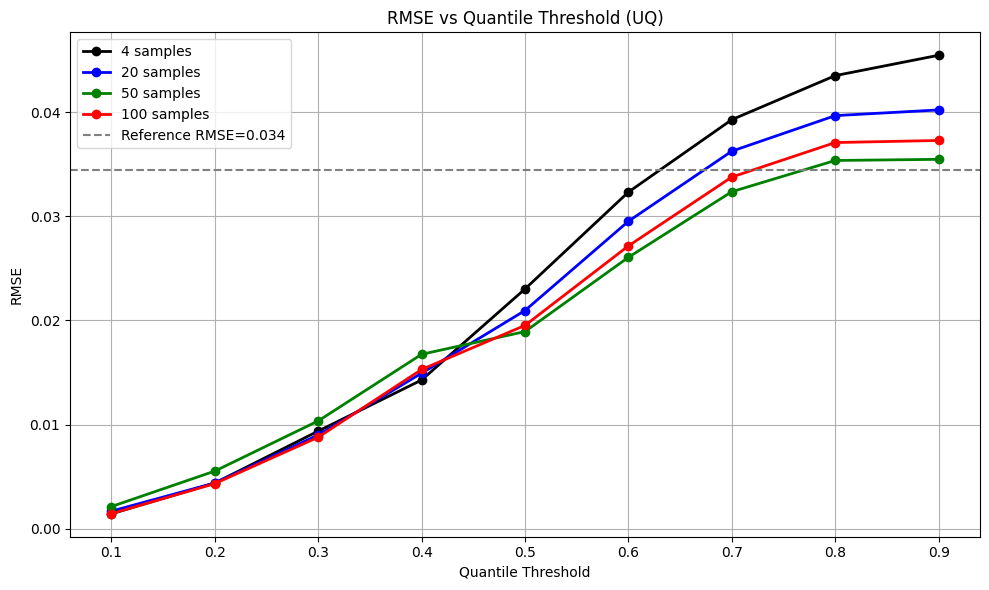

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rmse_4 = [0.001129, 0.003980, 0.008788, 0.014849, 0.024811, 0.034795, 0.042337, 0.047189, 0.049782]
rmse_20 = [0.001777, 0.004754, 0.009595, 0.016107, 0.019096, 0.026248, 0.032351, 0.035401, 0.035605]
rmse_50 = [0.001432, 0.004209, 0.008903, 0.015298, 0.018991, 0.025916, 0.032294, 0.035547, 0.035745]
rmse_100 = [0.002362, 0.005544, 0.010286, 0.015449, 0.020910, 0.029008, 0.035120, 0.038163, 0.038385]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, rmse_4, 'k-o', linewidth=2, label='4 samples')
plt.plot(thresholds, rmse_20, 'b-o', linewidth=2, label='20 samples')
plt.plot(thresholds, rmse_50, 'g-o', linewidth=2, label='50 samples')
plt.plot(thresholds, rmse_100, 'r-o', linewidth=2, label='100 samples')
plt.axhline(y=0.034, color='gray', linestyle='--', label='Reference RMSE=0.034')

plt.xlabel('Quantile Threshold')
plt.ylabel('RMSE')
plt.title('RMSE vs Quantile Threshold (UQ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'{logger.base_dir}/plot/rmse_vs_quantile_threshold.png')
plt.show()



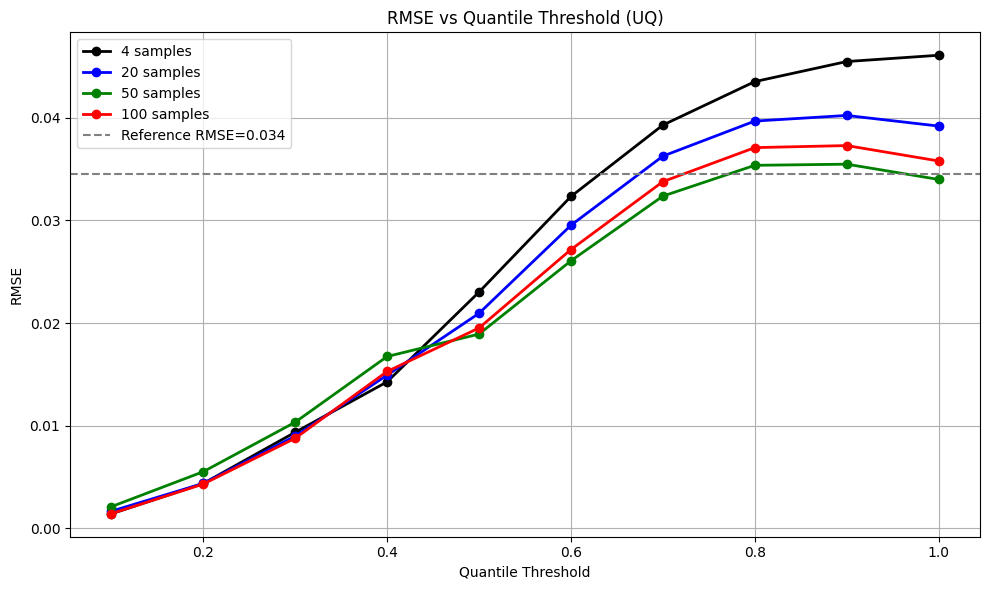

In [28]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rmse_4 = [0.00142300762489555, 0.004380123241346351, 0.009369710732808388, 0.014282235443586326, 0.023031536546467328, 0.032341578506220936, 0.03930020503907336, 0.043532904228550814, 0.04548896323934335, 0.0461]
rmse_20 = [0.001677327845523391, 0.0043836552068525604, 0.00899586712960883, 0.01493418106720577, 0.02095914968842816, 0.029535883569951283, 0.03627356836268057, 0.03968750182728127, 0.040235024383070236, 0.0392]
rmse_50 = [0.0021176287370649983, 0.005526386648061652, 0.010350073614117009, 0.0167493116019965, 0.01893471183537477, 0.026073014527093895, 0.03237745366873577, 0.035376872739089536, 0.03548727406318592, 0.0340]
rmse_100 = [0.0014387436426053712, 0.004323000342653018, 0.008782324506326216, 0.015290981907026156, 0.01952790435321419, 0.027167199733320213, 0.03378657380349548, 0.03710062030466379, 0.037300663715781134, 0.0358]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, rmse_4, 'k-o', linewidth=2, label='4 samples')
plt.plot(thresholds, rmse_20, 'b-o', linewidth=2, label='20 samples')
plt.plot(thresholds, rmse_50, 'g-o', linewidth=2, label='50 samples')
plt.plot(thresholds, rmse_100, 'r-o', linewidth=2, label='100 samples')
plt.axhline(y=0.0345, color='gray', linestyle='--', label='Reference RMSE=0.034')

plt.xlabel('Quantile Threshold')
plt.ylabel('RMSE')
plt.title('RMSE vs Quantile Threshold (UQ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'{logger.base_dir}/plots/rmse_vs_quantile_threshold.png')
plt.show()